In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os



*   HSV tạo ra tất cả các màu bằng cách phối hợp các thông tin về màu sắc (hue), độ bão hòa màu (saturation) và ánh sáng (value).




In [ ]:
folder_A = '/content/drive/MyDrive/folder_A'  # Replace with your folder A path
folder_B = '/content/drive/MyDrive/folder_B'  # Replace with your folder B path

# Ensure folder B exists
if not os.path.exists(folder_B):
    os.makedirs(folder_B)

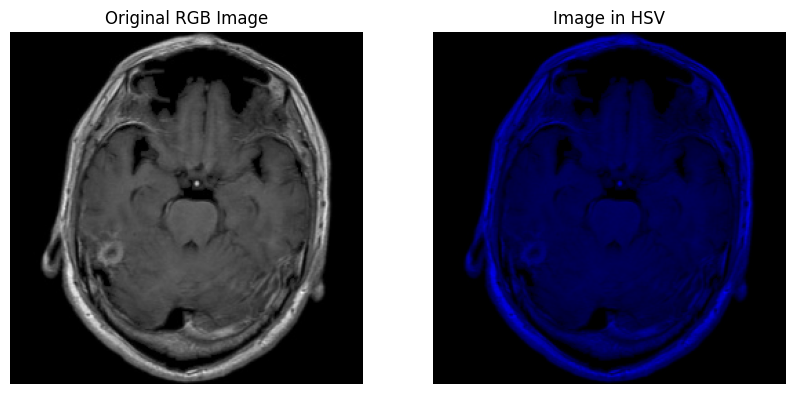

In [ ]:
# Áp dụng trên 1 ảnh cụ thể của dạng ung thư gilioma
image = cv2.imread('/content/drive/MyDrive/2023-2024/MRI_DATASET/glioma_tumor/G_10.jpg')

# Convert ảnh từ from BGR to RGB(ảnh gốc MRI là đen và trắng nên convert sang RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the RGB image to HSV
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)




*   Phân tích của ảnh HueSaturationB(S)brigthness
*   Sau đó lấy thông số của ảnh HSV được normalized




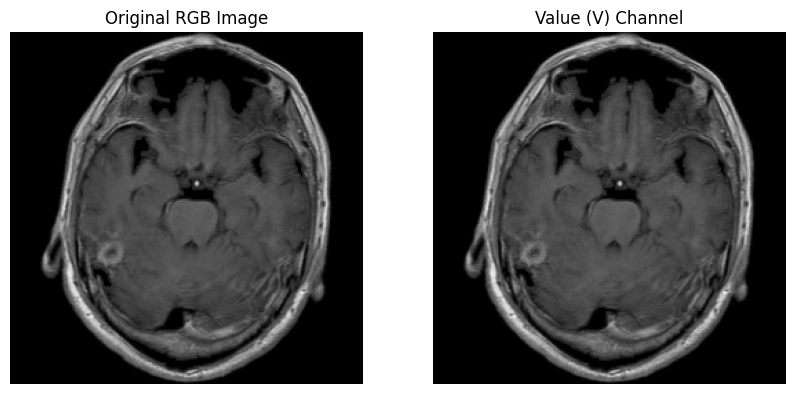

In [ ]:
# Extract the Value (V) channel from the HSV image
value_channel = image_hsv[:, :, 2] / 255.0





*   Viết hàm sigmoid 1/(1+e^(-x))_do không viết được Latex ...
*   Điều chỉnh contrast của ảnh
*   Áp dụng value channel qua hàm sigmoid và display lại ảnh ban đầu qua hàm






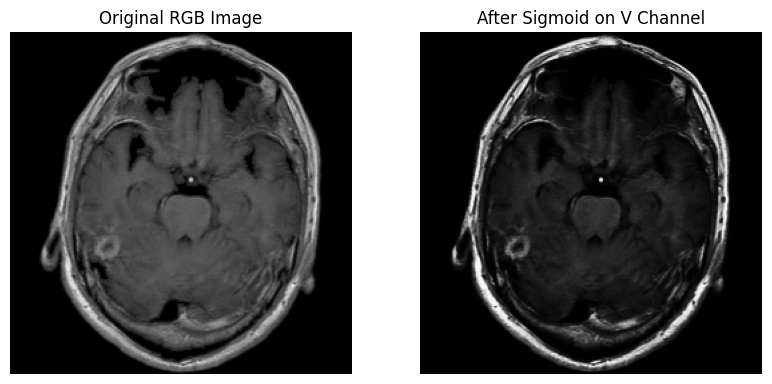

In [ ]:
# Sigmoid function with adaptive scaling
def sigmoid(x, gain=1, cutoff=0.5):
    return 1 / (1 + np.exp(-gain * (x - cutoff)))

# Apply the adaptive sigmoid transfer function on the Value channel
gain = 10  # Adjust this for more or less contrast
cutoff = 0.5  # Adjust this to center the contrast
value_channel_sigmoid = sigmoid(value_channel, gain=gain, cutoff=cutoff)

# Rescale the V channel back to [0, 255] range
value_channel_sigmoid = np.uint8(value_channel_sigmoid * 255)

# Update the V channel in the HSV image with the modified values
image_hsv[:, :, 2] = value_channel_sigmoid





*   Với mong muốn làm rõ những góc và vùng của não khác nhau, việc áp dụng Laplacian là điều cần thiết, em cũng đọc qua bài báo đã áp dụng phương pháp[https://www.sciencedirect.com/science/article/abs/pii/B9780128130872000038?via%3Dihub]
*   Làm nổi bật và cải thiện độ tương phản của ảnh[https://www.sciencedirect.com/science/article/abs/pii/B9780128130872000038?via%3Dihub]



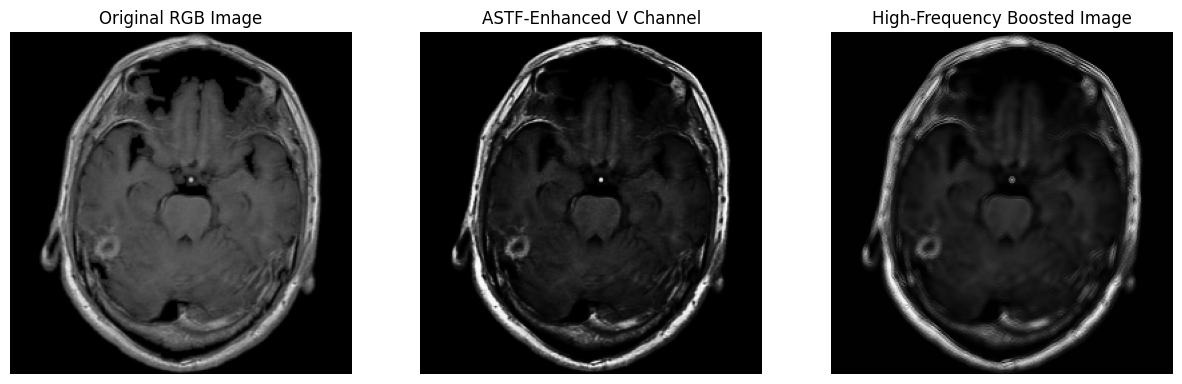

In [ ]:
# High-Frequency Boosting using a Laplacian filter
# Apply Laplacian to extract high-frequency components
laplacian = cv2.Laplacian(value_channel_sigmoid, cv2.CV_64F)

# Enhance the V channel by adding the high-frequency components to the ASTF-enhanced V channel
# You can scale the laplacian if needed to control the level of enhancement
high_boost = value_channel_sigmoid + 0.5 * laplacian  # Adjust the 0.5 factor as needed

# Clip values to ensure they are in the [0, 255] range
high_boost = np.clip(high_boost, 0, 255).astype(np.uint8)

# Update the V channel in the HSV image with the high-boosted values
image_hsv[:, :, 2] = high_boost

# Convert the image back to RGB
image_result = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)



Sau đó cải thiện những thông số của ảnh convert ngược lại từ HSV trở lại RGB

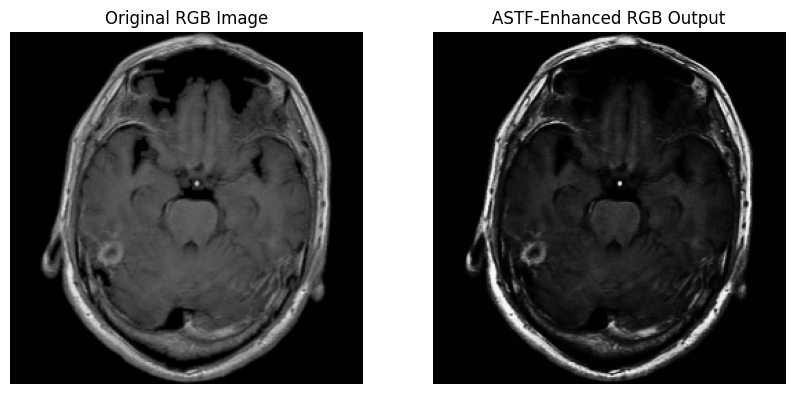

In [ ]:
# Apply the adaptive sigmoid transfer function on the Value channel
gain = 10  # Adjust this for more or less contrast
cutoff = 0.5  # Adjust this to center the contrast
value_channel_sigmoid = sigmoid(value_channel, gain=gain, cutoff=cutoff)

# Rescale the V channel back to [0, 255] range
value_channel_sigmoid = np.uint8(value_channel_sigmoid * 255)

# Update the V channel in the HSV image with the ASTF-enhanced values
image_hsv[:, :, 2] = value_channel_sigmoid

# Convert the enhanced HSV image back to RGB
image_result = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)


Phân tích và cải thiện Histogram của ảnh ban đầu
Kết quả là thu được ảnh với các đường viền rõ ràng hơn, khối u rõ nét hơn, phân biệt rõ ràng độ tương phản và chất lượng ảnh

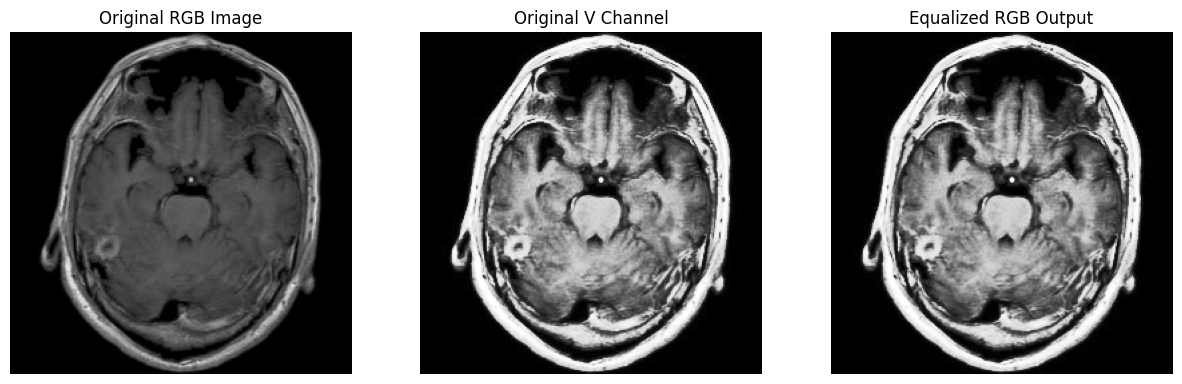

In [ ]:

# Convert the image from BGR (OpenCV default) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the RGB image to HSV
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# Extract the Value (V) channel from the HSV image
value_channel = image_hsv[:, :, 2]

# Apply Histogram Equalization to the V channel
equalized_v = cv2.equalizeHist(value_channel)

# Update the V channel in the HSV image with the equalized values
image_hsv[:, :, 2] = equalized_v

# Convert the image back to RGB
image_result = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

# Display the original RGB image, V channel before, and after histogram equalization
plt.figure(figsize=(15, 5))

# Display original RGB image
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original RGB Image')
plt.axis('off')

# Display original V channel
plt.subplot(1, 3, 2)
plt.imshow(value_channel, cmap='gray')
plt.title('Original V Channel')
plt.axis('off')

# Display equalized RGB image
plt.subplot(1, 3, 3)
plt.imshow(image_result)
plt.title('Equalized RGB Output')
plt.axis('off')

plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Function to compute sharpness (Laplacian variance method)
def compute_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var

# Function to compute contrast (standard deviation of pixel intensities)
def compute_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray)
    return contrast

# Function to compute brightness (mean pixel intensity)
def compute_brightness(image):
    brightness = np.mean(image)
    return brightness

# Function to compute PSNR (Peak Signal-to-Noise Ratio)
def compute_psnr(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')  # No noise between images
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

# Function to compute SSIM (Structural Similarity Index)
def compute_ssim(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    similarity = ssim(gray1, gray2)
    return similarity

# Load an image for testing
image = cv2.imread('your_image.jpg')

# Compute image quality metrics
sharpness = compute_sharpness(image)
contrast = compute_contrast(image)
brightness = compute_brightness(image)

# If comparing two images (original vs compressed or modified)
image2 = cv2.imread('another_image.jpg')  # Load another image for comparison
psnr_value = compute_psnr(image, image2)
ssim_value = compute_ssim(image, image2)

# Print out the results
print(f"Sharpness (Laplacian Variance): {sharpness}")
print(f"Contrast (Std Dev of Gray Intensities): {contrast}")
print(f"Brightness (Mean Pixel Intensity): {brightness}")
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


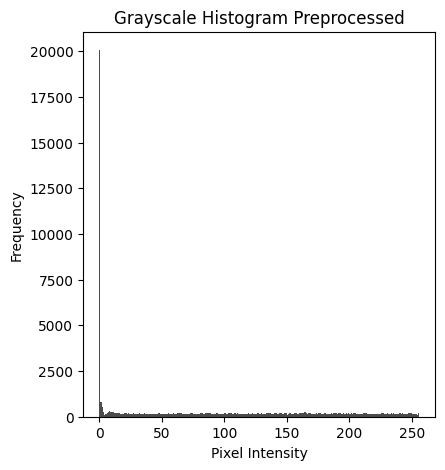

Mean pixel intensity (Grayscale): 85.79501342773438
Variance of pixel intensity (Grayscale): 7251.500552526675


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

# Define a function to compute basic statistics (mean, variance) of pixel intensities
def compute_statistics(image):
    mean = np.mean(image)
    variance = np.var(image)
    return mean, variance

# Define a function to plot histograms of pixel intensities
def plot_histogram(image, title, color_space='grayscale'):
    if color_space == 'grayscale':
        plt.hist(image.ravel(), bins=256, range=(0, 256), color='black', alpha=0.7)
    else:
        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            plt.plot(hist, color=color)
            plt.xlim([0, 256])
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

# Load image dataset (assuming the images are in a folder 'images/')
image_paths = glob('/content/drive/MyDrive/2023-2024/MRI_DATASET/data_preprocessed/glioma_tumor_processed/G_1.jpg')  # Adjust the path and extension as needed

# Initialize lists to store statistics for all images
means = []
variances = []

# Loop through the dataset, compute statistics, and plot histograms
for img_path in image_paths:
    # Load the image
    image = cv2.imread(img_path)

    # Convert to grayscale if needed for pixel intensity comparison
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute basic statistics for grayscale
    mean, variance = compute_statistics(grayscale_image)
    means.append(mean)
    variances.append(variance)

    # Plot histograms
    plt.figure(figsize=(10, 5))

    # Histogram for Grayscale
    plt.subplot(1, 2, 1)
    plot_histogram(grayscale_image, 'Grayscale Histogram Preprocessed')


    plt.show()

# Calculate and print the overall statistics
print(f"Mean pixel intensity (Grayscale): {np.mean(means)}")
print(f"Variance of pixel intensity (Grayscale): {np.mean(variances)}")


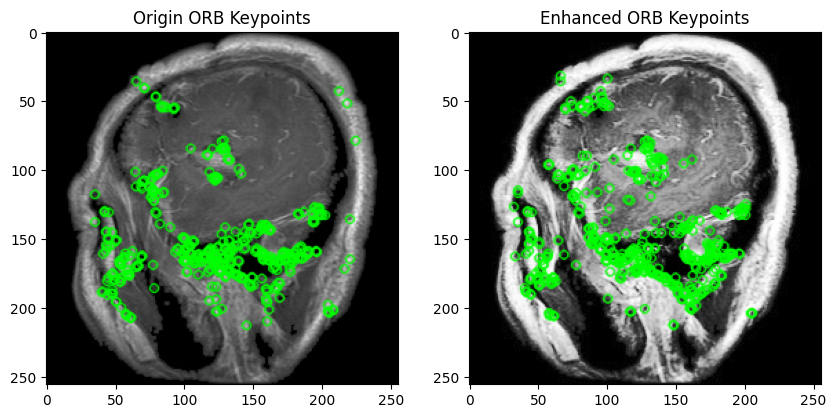

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the two images
image1_path = '/content/drive/MyDrive/2023-2024/MRI_DATASET/data_no_preprocess/glioma_tumor/G_7.jpg'
image2_path = '/content/drive/MyDrive/2023-2024/MRI_DATASET/data_preprocessed/glioma_tumor_processed/G_7.jpg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Convert to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect ORB features and compute descriptors
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Draw keypoints
image1_with_keypoints = cv2.drawKeypoints(image1, keypoints1, None, color=(0, 255, 0))
image2_with_keypoints = cv2.drawKeypoints(image2, keypoints2, None, color=(0, 255, 0))

# Display keypoints on both images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image1_with_keypoints)
plt.title('Origin ORB Keypoints')
plt.subplot(1, 2, 2)
plt.imshow(image2_with_keypoints)
plt.title('Enhanced ORB Keypoints')
plt.show()

# Initialize a Brute Force Matcher to compare ORB descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top 50 matches
match_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)



plt.show()
